In [2]:
# G.eval()
# model.eval()
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Memory allocated: {torch.cuda.memory_allocated(device)/(2**30):.2f} GB")
print(f"Memory reserved: {torch.cuda.memory_reserved(device)/(2**30):.2f} GB")


Memory allocated: 0.00 GB
Memory reserved: 0.00 GB


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_style("whitegrid")
sns.set_context("talk")

import sys
cfDir = "/accounts/grad/jeremy_goldwasser/Counterfactuals/"
styleganDir = cfDir + 'stylegan3-projector/'
sys.path.append(styleganDir)

import torch_utils
import dnnlib
import pickle

from SimpleCNNarchitecture import *
# import projection
import helper

from sklearn.linear_model import LogisticRegression

celebaDir = cfDir + "celeba/"
projectionDir = os.path.join(cfDir, 'cf_stylegan_celeba', 'projections')
predDir = celebaDir + "predictors/"
celebaDir = cfDir + "celeba/"
imDir = celebaDir + 'img_align_celeba/'


from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd

to_pil = transforms.ToPILImage()

# Evaluate model performance on subset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((178, 178)),
    transforms.Resize((256, 256))
])

w_fnames = os.listdir(projectionDir)

# Load saved dataframe
df = pd.read_pickle("cf_vecs/cf_vectors.pkl")

## Load attributes

In [4]:

attr = pd.read_csv(celebaDir+'list_attr_celeba.txt', sep='\s+', header=1)


## Load predictive model

## Load GAN

In [5]:
path = styleganDir+'results/network-snapshot-008800.pkl'
with open(path, 'rb') as fp:
    G = pickle.load(fp).to(device)


In [6]:
# os.environ["CUDA_HOME"] = "/usr/local/cuda"

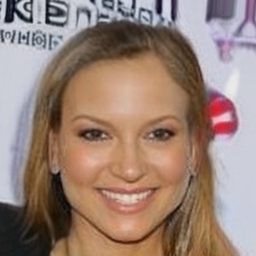

In [7]:
with torch.no_grad():
    z = torch.randn([1, G.z_dim]).cuda()    # latent codes
    c = None                                # class labels (not used in this example)
    img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1], no truncation
    im = img.squeeze().detach().cpu()
    im2 = ((im+1)/2).clamp(0, 1)
    display(to_pil(im2))

# Align with attribute labels

## Load latent vectors and assemble predictive labels

In [8]:
# Files are first 10k .jpgs, in order
w_fname_all = os.path.join(projectionDir, 'w_all_10k.pt')
X = torch.load(w_fname_all).detach().numpy()

In [9]:
# all_Ys = attr.iloc[:X.shape[0]].copy()
# all_Ys[all_Ys==-1] = 0
# all_Ys.head()

In [10]:

facial_hair = ((attr.Sideburns == 1) | (attr.Goatee == 1) | 
               (attr.No_Beard == -1) | (attr['5_o_Clock_Shadow']==1) | 
              (attr.Mustache == 1)).astype(int)
dark_hair = ((attr.Black_Hair == -1) | (attr.Brown_Hair==1)).astype(int)

overweight = ((attr.Chubby==1) | (attr.Double_Chin==1)).astype(int)

abstract_cols = ['Blurry', 'Mouth_Slightly_Open']
redundant_cols = ['Gray_Hair', 'Blond_Hair', 'Black_Hair', 'Brown_Hair',
                  'Sideburns', 'Goatee', 'No_Beard', '5_o_Clock_Shadow', 'Mustache',
                 'Chubby', 'Double_Chin']
exclude_cols_for_logreg = abstract_cols + redundant_cols
clean_Ys_with_modeled = pd.concat([attr.loc[:, ~attr.columns.isin(exclude_cols_for_logreg)],
                    facial_hair.rename("Facial_hair"),
                    dark_hair.rename("Dark_Hair"),
                    overweight.rename("Overweight")], axis=1).iloc[:X.shape[0]]

modeled_cols = ['Attractive', 'Young', 'Male']
clean_Ys = clean_Ys_with_modeled.loc[:, ~clean_Ys_with_modeled.columns.isin(modeled_cols)].copy()

clean_Ys_with_modeled[clean_Ys_with_modeled==-1] = 0
clean_Ys[clean_Ys==-1] = 0
clean_Ys.head()

Arched_Eyebrows  Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  \
000001.jpg                1                0     0      0         0         0   
000002.jpg                0                1     0      0         0         1   
000003.jpg                0                0     0      0         1         0   
000004.jpg                0                0     0      0         0         0   
000005.jpg                1                0     0      0         1         0   

            Bushy_Eyebrows  Eyeglasses  Heavy_Makeup  High_Cheekbones  ...  \
000001.jpg               0           0             1                1  ...   
000002.jpg               0           0             0                1  ...   
000003.jpg               0           0             0                0  ...   
000004.jpg               0           0             0                0  ...   
000005.jpg               0           0             1                0  ...   

            Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  \
000001.jpg              1          0                 1            0   
000002.jpg              0          0                 0            0   
000003.jpg              0          1                 0            0   
000004.jpg              1          0                 1            0   
000005.jpg              0          0                 0            0   

            Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Facial_hair  \
000001.jpg                 1                 0                0            0   
000002.jpg                 0                 0                0            0   
000003.jpg                 0                 0                0            0   
000004.jpg                 1                 1                0            0   
000005.jpg                 1                 0                0            0   

            Dark_Hair  Overweight  
000001.jpg          1           0  
000002.jpg          1           0  
000003.jpg          1           0  
000004.jpg          1           0  
000005.jpg          1           0  

[5 rows x 27 columns]

## Get logistic regression for relevant attributions

In [11]:
# logregs_path = os.path.join(cfDir, 'cf_stylegan_celeba', 'logregs.pkl')
logregs_path = os.path.join(cfDir, 'cf_stylegan_celeba', 'logregs_select.pkl')

with open(logregs_path, 'rb') as file:
    logregs = pickle.load(file)

exclude_cols = ['Smiling', 'Attractive', 'Male', 'Young']
filtered_logregs = {k: v for k, v in logregs.items() if k not in exclude_cols}
# filtered_logregs = logregs
print(len(filtered_logregs))

26


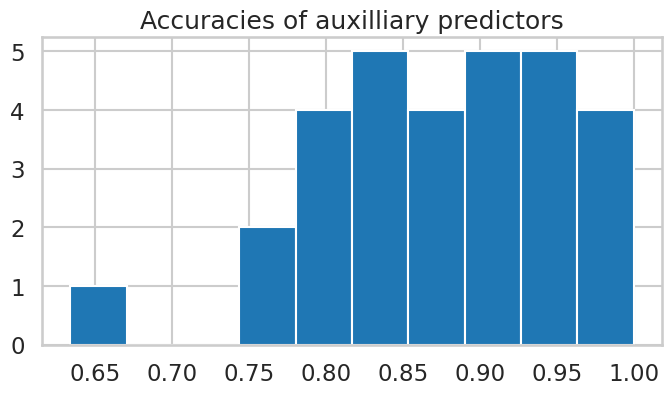

['Male' 'Pale_Skin' 'Eyeglasses' 'Wearing_Hat' 'Bald']
['Dark_Hair' 'Oval_Face' 'Pointy_Nose' 'Big_Lips' 'Attractive']


In [12]:
# Analyze models
accuracies = np.array([np.mean(logreg.predict(X)==clean_Ys_with_modeled[column]) for column, logreg in logregs.items()])
# accuracies = np.array([np.mean(logreg.predict(X)==all_Ys[column]) for column, logreg in logregs.items()])
plt.figure(figsize=(8, 4)); plt.title("Accuracies of auxilliary predictors"); plt.hist(accuracies); plt.show()

hardest = np.array(list(logregs.keys()))[np.argsort(accuracies)][:5]
easiest = np.array(list(logregs.keys()))[np.argsort(accuracies)][-5:]
print(easiest) # Male is easy, attractive is hard
print(hardest)

# Get counterfactual
Index 5 is Coach Beiste from Glee lol; works well for Attractive

Young, good images:
- Index 5: OK
- Index 27: labels OK
- Index 47: labels bad
- Index 56: labels p good
- Index 50: labels p good

In [13]:
def idx_to_img_and_vec(w_im_idx):
    w_fname = w_fnames[w_im_idx]

    # Load image
    idx_fname = w_fname.split('.')[0].split('_')[1]
    num_fname = str(int(idx_fname)+1)
    num_zeros_needed = 6-len(num_fname)
    padded_num_fname = '0'*num_zeros_needed+num_fname
    jpg_fname = padded_num_fname+'.jpg'
    image = Image.open(imDir + jpg_fname)
    
    # Reconstructed image
    w_vec = torch.load(os.path.join(projectionDir, w_fname)).to(device)

    image_tensor = transform(image).to(device)
    return w_vec, image_tensor


In [14]:
# Young, Smiling, Attractive, Male
Label = 'Young'
# Label = 'Attractive'

weights_path = predDir + Label.lower() + '_weights.pt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(weights_path))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

CF Prediction: 0.259
/accounts/grad/jeremy_goldwasser/Counterfactuals/celeba/predictors/young_weights.pt


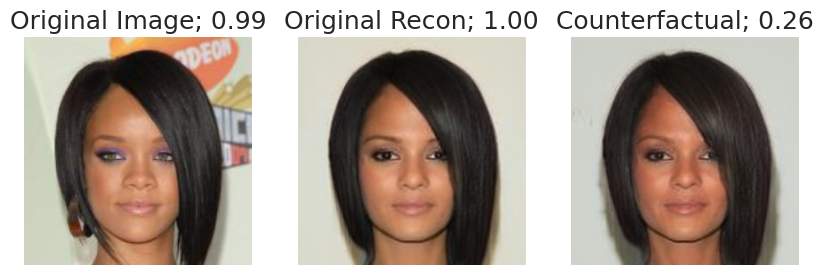

In [15]:
# 60,64,65,66, 67, 68, 75, 78, 79, 83, 91,  97, 98
w_im_idx = 47 #47, 67
w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)
w = torch.stack((w_vec,)*G.num_ws)

with torch.no_grad():
    pred_og = torch.sigmoid(model(image_tensor)).item()
    image_orig = image_tensor.cpu().permute(1,2,0)

    image_og_recon = helper.latent_to_image(G, w).clamp(0,1)[0]
    pred_recon = torch.sigmoid(model(image_og_recon)).item()
    image_og_recon = image_og_recon.cpu().permute(1,2,0)

df_label = df[df["Label"] == Label]
w_cf_vec = df_label[df_label["Index"]==w_im_idx]["CF"].item()
w_cf_vec = torch.tensor(w_cf_vec).squeeze().to(device)
# upper_thresh = 0.75; lower_thresh = 0.25
# # upper_thresh = 0.5; lower_thresh = 0.5
# if pred_recon<0.5:
#     w_cf_vec = helper.generate_counterfactual(G, w_vec, model, threshold=upper_thresh, 
#                                               binary=True, learning_rate=0.01, verbose=True)
# else:
#     w_cf_vec = helper.generate_counterfactual(G, w_vec, model, threshold=lower_thresh, 
#                                               binary=True, direction='decreasing', learning_rate=0.01, verbose=True)
w_cf = torch.stack((w_cf_vec,)*G.num_ws)

with torch.no_grad():
    image_cf = helper.latent_to_image(G, w_cf).clamp(0,1)
    pred_cf = torch.sigmoid(model(image_cf)).item()
    print(f'CF Prediction: {pred_cf:.3f}')
    image_cf = image_cf.cpu().squeeze().permute(1,2,0)
    # display(to_pil(image_cf))
    
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Display each image
axes[0].imshow(image_orig)
axes[0].set_title(f"Original Image; {pred_og:.2f}")
axes[0].axis('off')

axes[1].imshow(image_og_recon)
axes[1].set_title(f"Original Recon; {pred_recon:.2f}")
axes[1].axis('off')

axes[2].imshow(image_cf)
axes[2].set_title(f"Counterfactual; {pred_cf:.2f}")
axes[2].axis('off')

# Show the figure
print(weights_path)
# plt.suptitle(f"{Label}, Index {w_im_idx}" , size=18)
# plt.tight_layout()
plt.show()



# Compare counterfactual probabilities

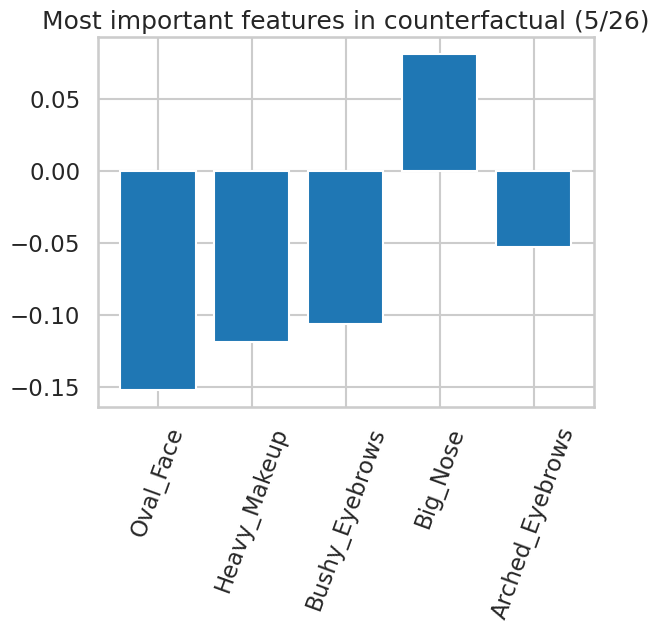

In [16]:
w_sklearn = w_vec.detach().cpu().reshape(1,-1)
probs_og = np.array([logreg.predict_proba(w_sklearn)[0,1] for _, logreg in filtered_logregs.items()])

w_cf_sklearn = w_cf_vec.detach().cpu().reshape(1,-1)
probs_cf = np.array([logreg.predict_proba(w_cf_sklearn)[0,1] for _, logreg in filtered_logregs.items()])

changes = probs_cf-probs_og
abs_changes = np.abs(changes)
order = np.argsort(abs_changes)[::-1]

# ordered_cols = attr.columns[~attr.columns.isin(exclude_cols)][order]
ordered_cols = clean_Ys.columns[~clean_Ys.columns.isin(exclude_cols)][order]
ordered_changes = changes[order]

num_features = 5
plt.title(f"Most important features in counterfactual ({num_features}/{len(filtered_logregs)})")
plt.bar(ordered_cols[:num_features], ordered_changes[:num_features])
plt.xticks(rotation=70)
plt.show()

# Visualize counterfactuals of different models

In [77]:
Labels = ['Young', 'Attractive', 'Male']
#        - e.g. young 50/56, attractive 5/21, male 3/56

# corresponding_idx = [21, 5, 3]
corresponding_idx = [91, 27, 56] # Uncomment this to generate alternate figure
results_cfs = []
torch.manual_seed(1)
for i, Label in enumerate(Labels):
    print(i)
    # if i==0:
    #     continue
    weights_path = predDir + Label.lower() + '_weights.pt'
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load(weights_path))
    model.eval()
    
    w_im_idx = corresponding_idx[i]
    w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)
    w = torch.stack((w_vec,)*G.num_ws)
    
    # image_tensor = transform(image).to(device)
    with torch.no_grad():
        pred_og = torch.sigmoid(model(image_tensor)).item()
        image_orig = image_tensor.cpu().permute(1,2,0)
    
        image_og_recon = helper.latent_to_image(G, w).clamp(0,1)[0]
        pred_recon = torch.sigmoid(model(image_og_recon)).item()
        image_og_recon = image_og_recon.cpu().permute(1,2,0)

    df_label = df[df["Label"] == Label]
    w_cf_vec = df_label[df_label["Index"]==w_im_idx]["CF"].item()
    w_cf_vec = torch.tensor(w_cf_vec).squeeze().to(device)
    # upper_thresh = 0.75; lower_thresh = 0.25
    # # upper_thresh = 0.5; lower_thresh = 0.5
    # if pred_recon<0.5:
    #     w_cf_vec = helper.generate_counterfactual(G, w_vec, model, threshold=upper_thresh, 
    #                                               binary=True, learning_rate=0.01, verbose=True)
    # else:
    #     w_cf_vec = helper.generate_counterfactual(G, w_vec, model, threshold=lower_thresh, 
    #                                               binary=True, direction='decreasing', learning_rate=0.01, verbose=True)
    w_cf = torch.stack((w_cf_vec,)*G.num_ws)
    
    with torch.no_grad():
        image_cf = helper.latent_to_image(G, w_cf).clamp(0,1)
        pred_cf = torch.sigmoid(model(image_cf)).item()
        print(f'CF Prediction: {pred_cf:.3f}')
        image_cf = image_cf.cpu().squeeze().permute(1,2,0)
    
    w_sklearn = w_vec.detach().cpu().reshape(1,-1)
    probs_og = np.array([logreg.predict_proba(w_sklearn)[0,1] for _, logreg in filtered_logregs.items()])
    
    w_cf_sklearn = w_cf_vec.detach().cpu().reshape(1,-1)
    probs_cf = np.array([logreg.predict_proba(w_cf_sklearn)[0,1] for _, logreg in filtered_logregs.items()])
    
    changes = probs_cf-probs_og
    abs_changes = np.abs(changes)
    order = np.argsort(abs_changes)[::-1]
    
    # ordered_cols = attr.columns[~attr.columns.isin(exclude_cols)][order]
    ordered_cols = clean_Ys.columns[~clean_Ys.columns.isin(exclude_cols)][order]
    ordered_changes = changes[order]
    
    num_features = 5
    top_names, top_vals = ordered_cols[:num_features], ordered_changes[:num_features]

    results_cf = (image_orig, image_cf, top_names, top_vals)
    results_cfs.append(results_cf)


0
CF Prediction: 0.234
1
CF Prediction: 0.223
2
CF Prediction: 0.200


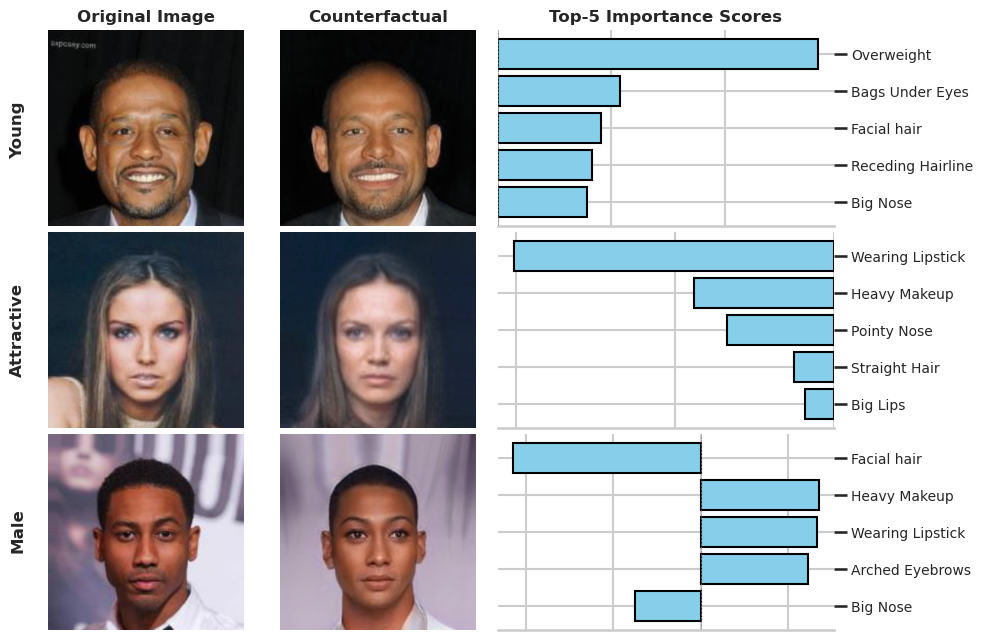

In [78]:
fig = plt.figure(figsize=(8, 6))
margin = 0.01

x = (1.0 - 2*margin) / 3.5
y = (1.0 - 2*margin) / 3.0

axes = [[None]*3 for _ in range(3)]

for i in range(3):
    bottom = (2 - i) * (y + margin)
    
    # Column 0 (width = x), left=0
    left0 = 0.0
    axes[i][0] = fig.add_axes([left0, bottom, x, y])
    
    # Column 1 (width = x), abuts col0 with margin
    left1 = x + margin
    axes[i][1] = fig.add_axes([left1, bottom, x, y])
    
    # Column 2 (width = 1.5x), abuts col1 with margin
    left2 = 2*x + 2*margin
    axes[i][2] = fig.add_axes([left2, bottom, 1.5*x, y])

# Set column titles on the top row
axes[0][0].set_title("Original Image", fontsize=12, fontweight='bold')
axes[0][1].set_title("Counterfactual", fontsize=12, fontweight='bold')
axes[0][2].set_title("Top-5 Importance Scores", fontsize=12, fontweight='bold')

for i, (image_orig, image_cf, top_names, top_vals) in enumerate(results_cfs):
    # Show images
    axes[i][0].imshow(image_orig)
    axes[i][0].axis('off')
    axes[i][1].imshow(image_cf)
    axes[i][1].axis('off')
    
    # Replace underscores with spaces in the labels
    modified_top_names = [name.replace("_", " ") for name in top_names]
    
    # Horizontal bar chart with no wrapping
    axes[i][2].barh(modified_top_names, top_vals, color="skyblue", edgecolor="black")
    axes[i][2].invert_yaxis()  # top_names[0] at the top
    
    # Mark x=0 with a subtle vertical line
    axes[i][2].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    
    # Place bar-chart y labels on the RIGHT
    axes[i][2].yaxis.tick_right()
    axes[i][2].yaxis.set_label_position("right")
    sns.despine(ax=axes[i][2], top=True, left=True)
    axes[i][2].tick_params(axis='y', labelsize=10)
    
    # Disable x-axis labels for the bar plot
    axes[i][2].tick_params(axis='x', labelbottom=False)
    
    # Vertical label on the left inside the figure
    row_center = 0.5 - (i-1)/3
    fig.text(
        -0.03, 
        row_center,
        Labels[i],
        rotation=90,
        va='center',
        ha='left',
        fontsize=12,
        fontweight='bold'
    )

os.makedirs("Figures", exist_ok=True)
# plt.savefig("Figures/CelebA/labeled_cfs.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.savefig("Figures/CelebA/labeled_cfs2.pdf", bbox_inches="tight", format="pdf", dpi=300) # Uncomment this to generate alternate figure
plt.show()

# Hair failure for woman

CF Prediction: 0.824


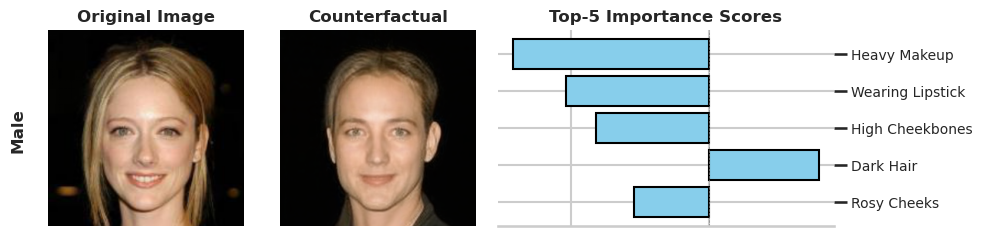

In [74]:
Label = 'Male'
weights_path = predDir + Label.lower() + '_weights.pt'
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(weights_path))
model.eval()

w_im_idx = 21
w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)
w = torch.stack((w_vec,)*G.num_ws)

with torch.no_grad():
    pred_og = torch.sigmoid(model(image_tensor)).item()
    image_orig = image_tensor.cpu().permute(1,2,0)

    image_og_recon = helper.latent_to_image(G, w).clamp(0,1)[0]
    pred_recon = torch.sigmoid(model(image_og_recon)).item()
    image_og_recon = image_og_recon.cpu().permute(1,2,0)

df_label = df[df["Label"] == Label]
w_cf_vec = df_label[df_label["Index"]==w_im_idx]["CF"].item()
w_cf_vec = torch.tensor(w_cf_vec).squeeze().to(device)
# upper_thresh = 0.75; lower_thresh = 0.25
# if pred_recon<0.5:
#     w_cf_vec = helper.generate_counterfactual(G, w_vec, model, threshold=upper_thresh, 
#                                               binary=True, learning_rate=0.01, verbose=True)
# else:
#     w_cf_vec = helper.generate_counterfactual(G, w_vec, model, threshold=lower_thresh, 
#                                               binary=True, direction='decreasing', learning_rate=0.01, verbose=True)
w_cf = torch.stack((w_cf_vec,)*G.num_ws)

with torch.no_grad():
    image_cf = helper.latent_to_image(G, w_cf).clamp(0,1)
    pred_cf = torch.sigmoid(model(image_cf)).item()
    print(f'CF Prediction: {pred_cf:.3f}')
    image_cf = image_cf.cpu().squeeze().permute(1,2,0)

w_sklearn = w_vec.detach().cpu().reshape(1,-1)
probs_og = np.array([logreg.predict_proba(w_sklearn)[0,1] for _, logreg in filtered_logregs.items()])

w_cf_sklearn = w_cf_vec.detach().cpu().reshape(1,-1)
probs_cf = np.array([logreg.predict_proba(w_cf_sklearn)[0,1] for _, logreg in filtered_logregs.items()])

changes = probs_cf-probs_og
abs_changes = np.abs(changes)
order = np.argsort(abs_changes)[::-1]

ordered_cols = clean_Ys.columns[~clean_Ys.columns.isin(exclude_cols)][order]
ordered_changes = changes[order]

num_features = 5
top_names, top_vals = ordered_cols[:num_features], ordered_changes[:num_features]

fig = plt.figure(figsize=(8, 6))
margin = 0.01

x = (1.0 - 2*margin) / 3.5
y = (1.0 - 2*margin) / 3.0

# axes = [[None]*3 for _ in range(3)]
axes = [None]*3

i = 0
bottom = (2 - i) * (y + margin)

# Column 0 (width = x), left=0
left0 = 0.0
axes[0] = fig.add_axes([left0, bottom, x, y])

# Column 1 (width = x), abuts col0 with margin
left1 = x + margin
axes[1] = fig.add_axes([left1, bottom, x, y])

# Column 2 (width = 1.5x), abuts col1 with margin
left2 = 2*x + 2*margin
axes[2] = fig.add_axes([left2, bottom, 1.5*x, y])

# Set column titles on the top row
axes[0].set_title("Original Image", fontsize=12, fontweight='bold')
axes[1].set_title("Counterfactual", fontsize=12, fontweight='bold')
axes[2].set_title("Top-5 Importance Scores", fontsize=12, fontweight='bold')


# Show images
axes[0].imshow(image_orig)
axes[0].axis('off')
axes[1].imshow(image_cf)
axes[1].axis('off')

# Replace underscores with spaces in the labels
modified_top_names = [name.replace("_", " ") for name in top_names]

# Horizontal bar chart with no wrapping
axes[2].barh(modified_top_names, top_vals, color="skyblue", edgecolor="black")
axes[2].invert_yaxis()  # top_names[0] at the top

# Mark x=0 with a subtle vertical line
axes[2].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)

# Place bar-chart y labels on the RIGHT
axes[2].yaxis.tick_right()
axes[2].yaxis.set_label_position("right")
sns.despine(ax=axes[2], top=True, left=True)
axes[2].tick_params(axis='y', labelsize=10)

# Disable x-axis labels for the bar plot
axes[2].tick_params(axis='x', labelbottom=False)

# Vertical label on the left inside the figure
row_center = 0.5 - (i-1)/3
fig.text(
    -0.03, 
    row_center,
    "Male",
    rotation=90,
    va='center',
    ha='left',
    fontsize=12,
    fontweight='bold'
)

os.makedirs("Figures", exist_ok=True)
plt.savefig("Figures/CelebA/hair_gender_failure.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()

# Global counterfactual scores

In [75]:
global_names = ['Young', 'Attractive', 'Male']
num_features = 5  # number of top features to show

results = {}
for label in global_names:
    df_label = df[df["Label"] == label]
    per_image_diffs = []
    
    for _, row in df_label.iterrows():
        # Retrieve the corresponding original vector using the stored index.
        image_idx = row["Index"]
        w_fname = w_fnames[image_idx]
        
        # Load original vector (assumes the file contains a tensor)
        w_vec = torch.load(os.path.join(projectionDir, w_fname)).to("cpu")
        w_original = w_vec.detach().cpu().numpy().reshape(1, -1)
        
        # Get the stored counterfactual vector and original prediction
        w_cf_vec = row["CF"]
        pred_og = row["pred_recon"]
        # Decide the sign based on the original prediction.
        dir_sign = 1 if pred_og < 0.5 else -1
        
        # Compute differences for each logistic regression
        diffs = []
        for _, logreg in filtered_logregs.items():
            prob_orig = logreg.predict_proba(w_original)[0, 1]
            prob_cf = logreg.predict_proba(w_cf_vec)[0, 1]
            diffs.append(prob_cf - prob_orig)
        diffs = np.array(diffs) * dir_sign
        per_image_diffs.append(diffs)
    
    # Compute the average change and order features by the magnitude of change
    avg_changes = np.mean(per_image_diffs, axis=0)
    avg_abs_changes = np.abs(avg_changes)
    order = np.argsort(avg_abs_changes)[::-1]
    
    # Get the ordered feature names from clean_Ys (excluding some columns)
    ordered_cols = clean_Ys.columns[~clean_Ys.columns.isin(exclude_cols)][order]
    ordered_changes = avg_changes[order]
    
    # Select the top features
    top_names = ordered_cols[:num_features]
    top_vals = ordered_changes[:num_features]
    
    # Replace underscores with spaces for readability
    modified_top_names = [name.replace("_", " ") for name in top_names]
    results[label] = (modified_top_names, top_vals)

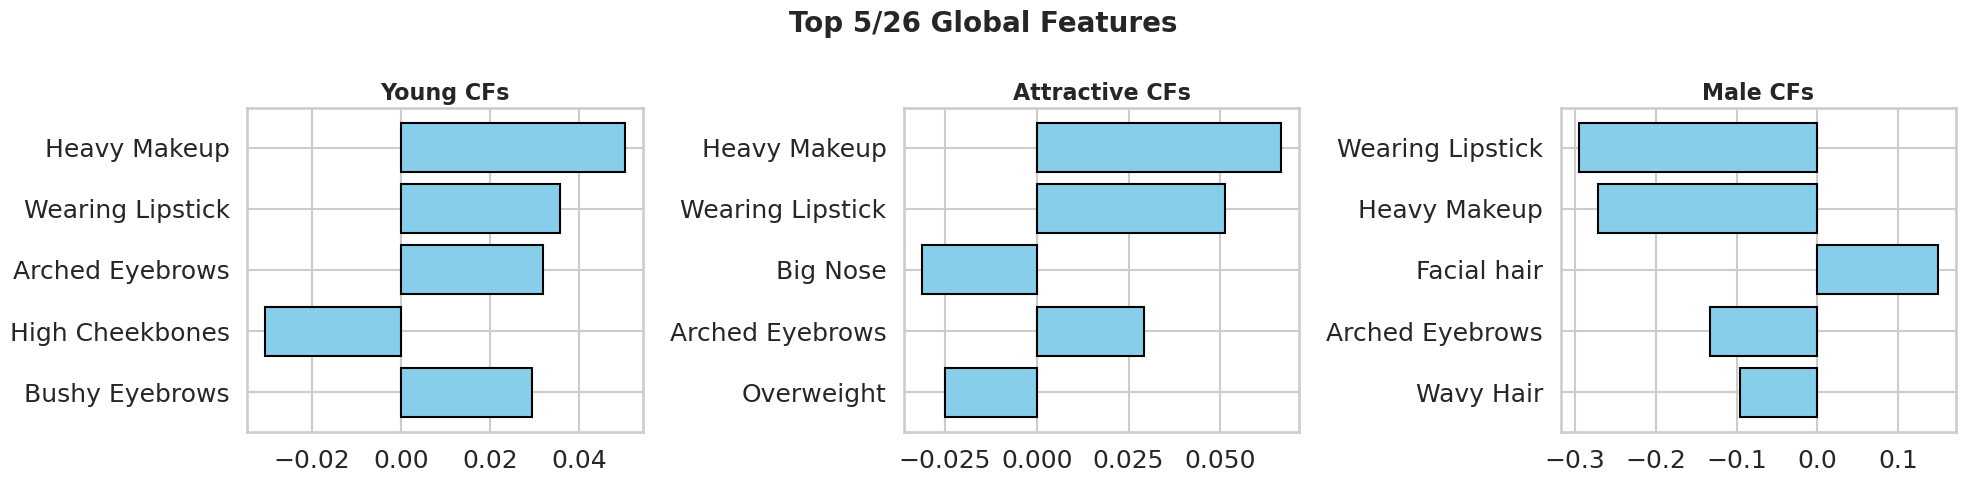

In [76]:
fig, axes = plt.subplots(1, len(global_names), figsize=(6*len(global_names)+2, 5))
fig.suptitle(f"Top {num_features}/{len(filtered_logregs)} Global Features", fontsize=20, fontweight="bold")
fig.subplots_adjust(wspace=0.4)

for i, label in enumerate(global_names):
    modified_top_names, top_vals = results[label]
    ax = axes[i]
    ax.barh(modified_top_names, top_vals, color="skyblue", edgecolor="black")
    ax.invert_yaxis()
    ax.set_title(f"{label} CFs", fontsize=16, fontweight="bold")
    # Increase the font size of both x and y tick labels (here y ticks are the feature names)
    ax.tick_params(axis="both", labelsize=18)
    
plt.tight_layout()
plt.savefig("Figures/CelebA/global_scores.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()

# Examples of bad reconstructions

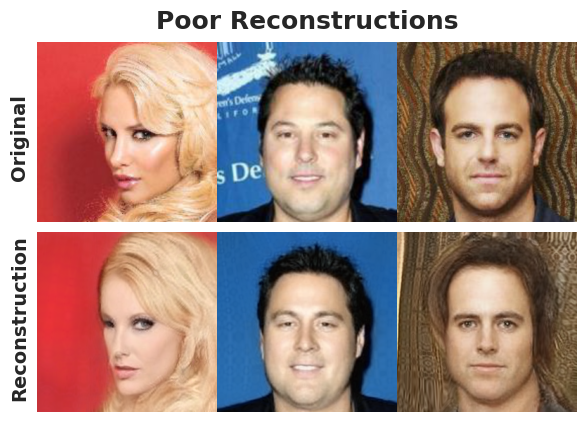

In [133]:
bad_idx = [45, 19, 11]
n = len(bad_idx)

fig, axes = plt.subplots(
    2, n,
    figsize=(1.8 * n, 4),  # Adjust width to your preference
    gridspec_kw={"wspace": 0, "hspace": 0}
)

for j, w_im_idx in enumerate(bad_idx):
    w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)
    w = torch.stack([w_vec] * G.num_ws)

    with torch.no_grad():
        image_orig = image_tensor.cpu().permute(1, 2, 0)
        image_og_recon = helper.latent_to_image(G, w).clamp(0, 1)[0].cpu().permute(1, 2, 0)

    axes[0, j].imshow(image_orig)
    axes[0, j].axis("off")
    axes[1, j].imshow(image_og_recon)
    axes[1, j].axis("off")

# Remove almost all figure margins
plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0, wspace=0, hspace=0)

fig.suptitle("Poor Reconstructions", fontsize=18, fontweight="bold", y=1.02)

# Row labels on the far left
fig.text(-0.05, 0.7, "Original", fontsize=14, fontweight="bold", va="center", rotation=90)
fig.text(-0.05, 0.25, "Reconstruction", fontsize=14, fontweight="bold", va="center", rotation=90)
plt.savefig("Figures/CelebA/poor_recons.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()

# Smiling Counterfactuals

In [226]:
w_im_idx

45

64
66
74
78
79
83


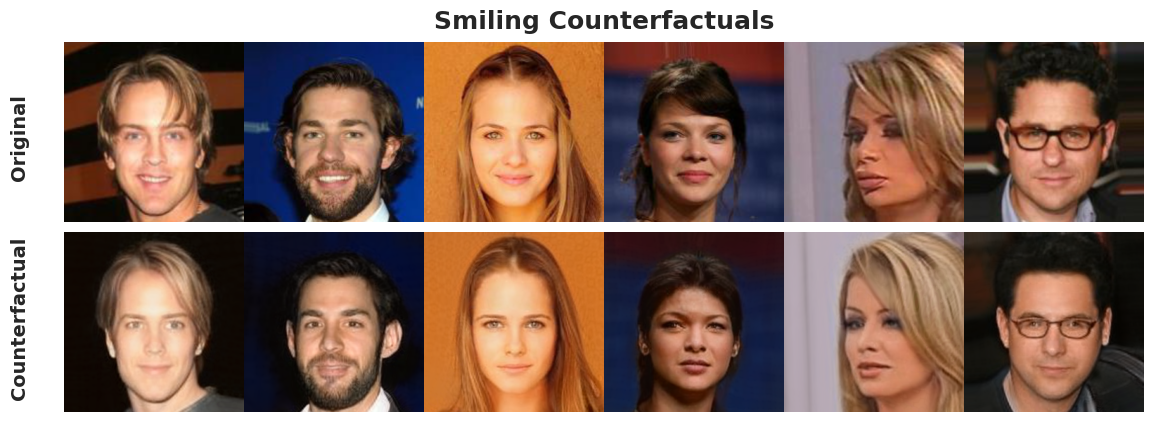

In [23]:
Label = 'Smiling'
weights_path = predDir + Label.lower() + '_weights.pt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(weights_path))
model.eval()
# 64, 66, 74, 78, 79, 83 
good_idx = [64, 66, 74, 78, 79, 83]
n = len(good_idx)

fig, axes = plt.subplots(
    2, n,
    figsize=(1.8 * n, 4),  # Adjust width to your preference
    gridspec_kw={"wspace": 0, "hspace": 0}
)

for j, w_im_idx in enumerate(good_idx):
    print(w_im_idx)
    w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)
    w = torch.stack([w_vec] * G.num_ws)

    df_label = df[df["Label"] == Label]
    w_cf_vec = df_label[df_label["Index"]==w_im_idx]["CF"].item()
    w_cf_vec = torch.tensor(w_cf_vec).squeeze().to(device)
    w_cf = torch.stack((w_cf_vec,)*G.num_ws)

    with torch.no_grad():
        image_orig = image_tensor.cpu().permute(1, 2, 0)
        
        image_cf = helper.latent_to_image(G, w_cf).clamp(0,1)
        image_cf = image_cf.cpu().squeeze().permute(1,2,0)

    axes[0, j].imshow(image_orig)
    axes[0, j].axis("off")
    axes[1, j].imshow(image_cf)
    axes[1, j].axis("off")

# Remove almost all figure margins
plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0, wspace=0, hspace=0)

fig.suptitle("Smiling Counterfactuals", fontsize=18, fontweight="bold", y=1.02)

# Row labels on the far left
fig.text(-0.05, 0.7, "Original", fontsize=14, fontweight="bold", va="center", rotation=90)
fig.text(-0.05, 0.25, "Counterfactual", fontsize=14, fontweight="bold", va="center", rotation=90)
plt.savefig("Figures/CelebA/smiling_cfs.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()

In [18]:
# df_label[df_label["Index"]==w_im_idx]#["CF"]
w_im_idx

32

# Diversity (not working)

In [13]:
Label = 'Young'
weights_path = predDir + Label.lower() + '_weights.pt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(weights_path))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [14]:
w_im_idx = 67 #47, 67
w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)
w = torch.stack((w_vec,)*G.num_ws)
with torch.no_grad():
    pred_og = torch.sigmoid(model(image_tensor)).item()
    image_orig = image_tensor.cpu().permute(1,2,0)

    image_og_recon = helper.latent_to_image(G, w).clamp(0,1)[0]
    pred_recon = torch.sigmoid(model(image_og_recon)).item()
    # image_og_recon = image_og_recon.cpu().permute(1,2,0)
upper_thresh = 0.75; lower_thresh = 0.25
# upper_thresh = 0.5; lower_thresh = 0.5

In [15]:
image_cfs = []
n_diverse_ims = 3
for i in range(n_diverse_ims):    
    print(i)
    if pred_recon<0.5:
        w_cf_vec = helper.generate_counterfactual(G, w_vec, model, threshold=upper_thresh, 
                                                  binary=True, learning_rate=0.01, verbose=True)
    else:
        w_cf_vec = helper.generate_counterfactual(G, w_vec, model, threshold=lower_thresh, 
                                                  binary=True, direction='decreasing', learning_rate=0.01, verbose=True)
    
    with torch.no_grad():
        w_cf = torch.stack((w_cf_vec,)*G.num_ws)
        image_cf = helper.latent_to_image(G, w_cf).clamp(0,1)
        image_cfs.append(image_cf)

0
7 [0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.34, 0.81]
1
7 [0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.36, 0.81]
2
7 [0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.35, 0.87]


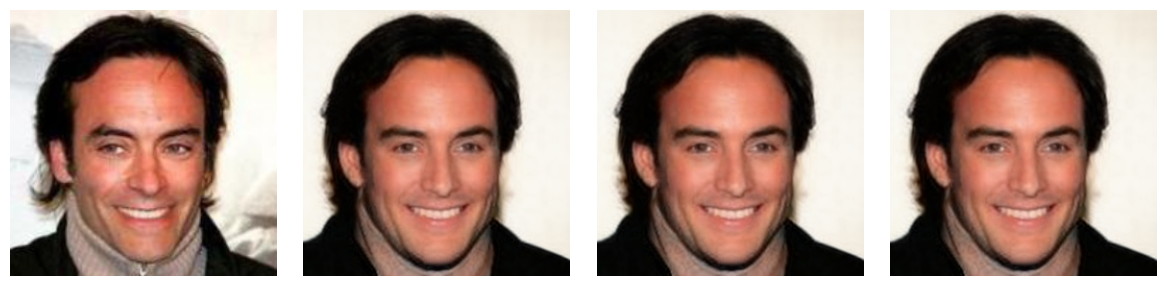

In [16]:
# n_diverse_ims = 3
thresh = upper_thresh if pred_recon<0.5 else lower_thresh

fig, axes = plt.subplots(1, n_diverse_ims+1, figsize=(12, 4))

# Display each image
axes[0].imshow(image_orig)
# axes[0].set_title(f"Original Image; {pred_og:.2f}")
axes[0].axis('off')

# axes[1].set_title(f"Counterfactuals; {thresh:.2f}")
for i in range(n_diverse_ims):
    image_cf = image_cfs[i]
    image_cf = image_cf.cpu().squeeze().permute(1,2,0)
    axes[i+1].imshow(image_cf)
    axes[i+1].axis('off')

# Show the figure
# plt.suptitle(f"{Label}, Index {w_im_idx}" , size=18)
plt.tight_layout()
plt.show()



In [17]:
# # Instead of relying on noise_mode, manually supply different noise dictionaries:

# a = G.synthesis(w_cf.unsqueeze(0), noise_mode='const')
# b = G.synthesis(w_cf.unsqueeze(0), noise_mode='random')
# c = G.synthesis(w_cf.unsqueeze(0), noise_mode='none')


In [41]:
# print((a != c).sum())

tensor(0, device='cuda:0')


# Lot of reconstructions

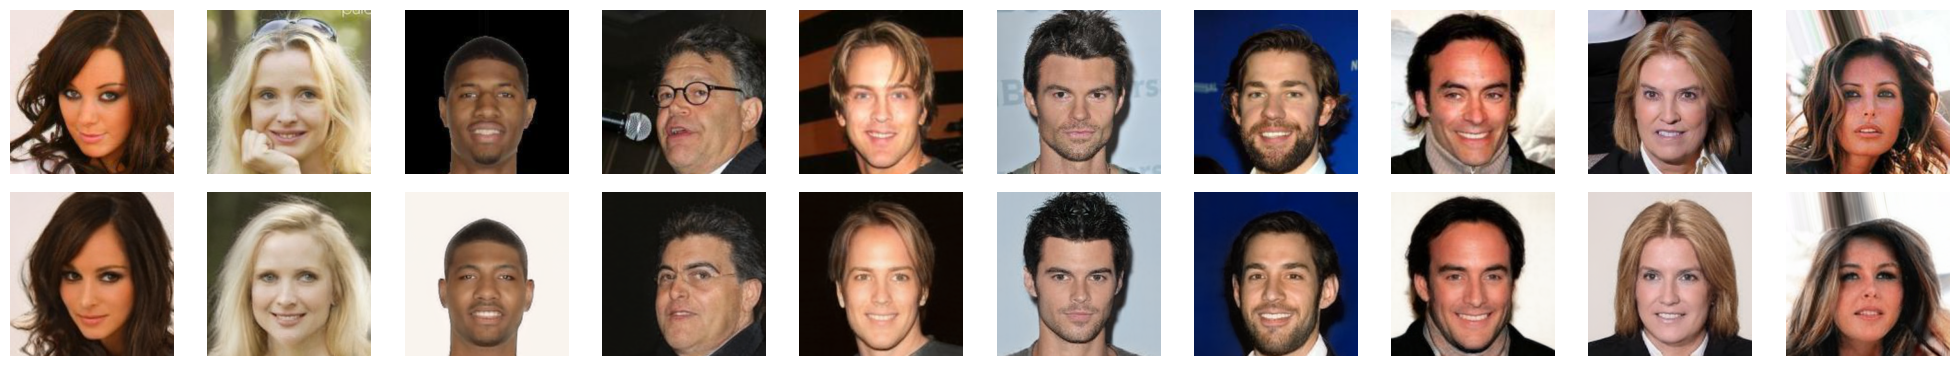

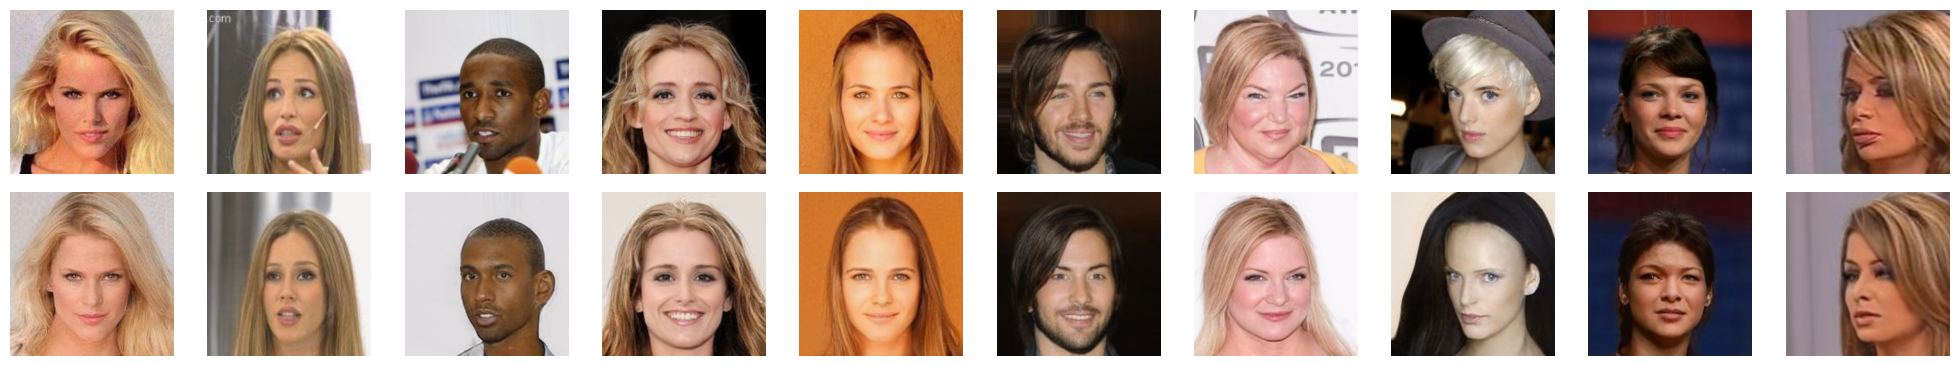

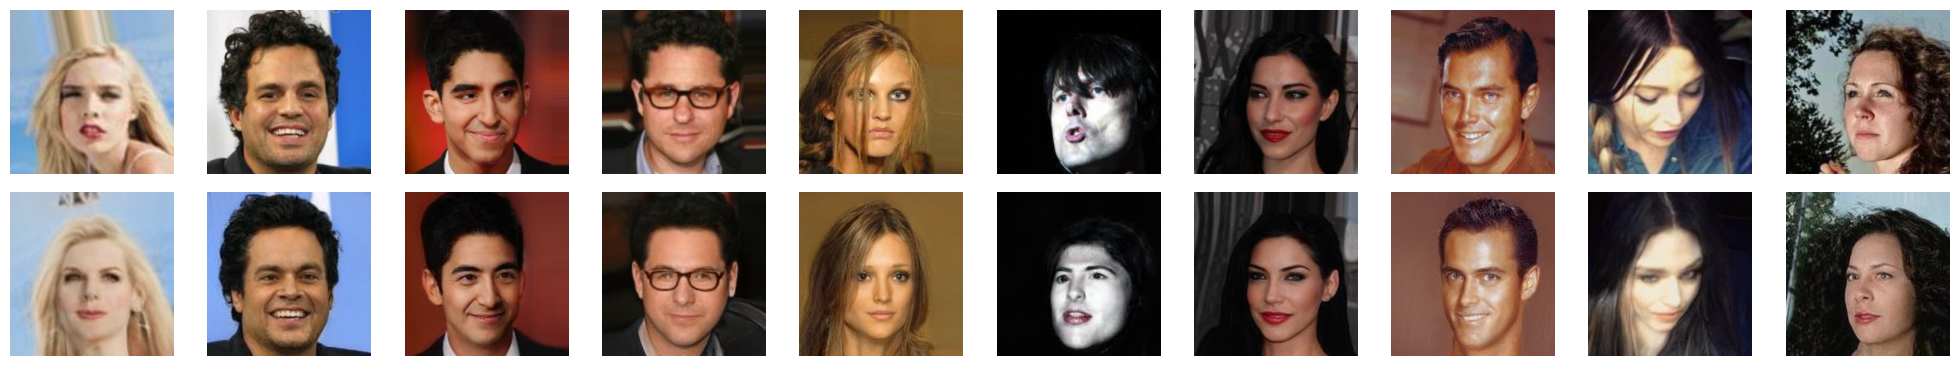

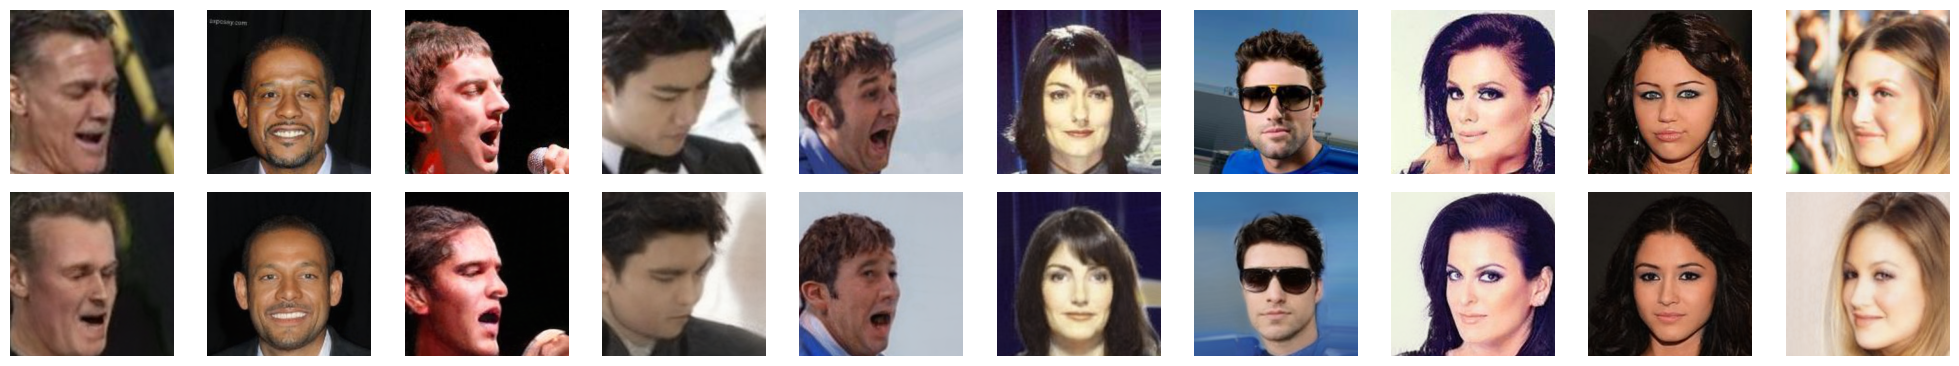

In [134]:
# importlib.reload(helper)
for i in range(4):
    num_cfs = 10
    fig, axes = plt.subplots(2, num_cfs, figsize=(20, 4))
    start_idx = i*num_cfs+60
    for w_im_idx in range(num_cfs):
        # Load latent vector w
        w_fname = w_fnames[start_idx+w_im_idx]
        w_vec = torch.load(os.path.join(projectionDir, w_fname)).to(device)
        # w_vec.retain_grad()

        # Load image
        idx_fname = w_fname.split('.')[0].split('_')[1]
        num_fname = str(int(idx_fname)+1)
        num_zeros_needed = 6-len(num_fname)
        padded_num_fname = '0'*num_zeros_needed+num_fname
        jpg_fname = padded_num_fname+'.jpg'
        image = Image.open(imDir + jpg_fname)
        image_tensor = transform(image).to(device)

        # Obtain original and reconstructed image
        with torch.no_grad():
            image_orig = image_tensor.cpu().permute(1,2,0)
            
            w = torch.stack((w_vec,)*G.num_ws)
            image_og_recon = helper.latent_to_image(G, w).clamp(0,1)[0]
            image_og_recon = image_og_recon.cpu().permute(1,2,0)

        axes[0,w_im_idx].imshow(image_orig)
        axes[0,w_im_idx].axis('off')

        axes[1,w_im_idx].imshow(image_og_recon)
        axes[1,w_im_idx].axis('off')
        del w, w_vec, image_tensor
        torch.cuda.empty_cache()
    fig.tight_layout()
    plt.show()
# 60,64,65,66, 67, 68, 74, 75, 78, 79, 83, 91, 94, 95, 96, 97, 98

# Counterfactuals of InterFaceGAN

### Test Accuracy

In [21]:
from sklearn.model_selection import train_test_split

seed = 42
for col in modeled_cols:
    X_train, X_test, y_train, y_test = train_test_split(X, clean_Ys_with_modeled[col], test_size=0.2, random_state=seed)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    acc = (logreg.predict(X_test) == y_test).mean()
    print(col, acc * 100)

# 80\% for attractive, 87\% for youth, and 90\% for gender
# So logreg is better on Male, but 3% worse for attractive and young.

Attractive 77.75
Young 84.2
Male 93.10000000000001


In [25]:
def get_interfacegan_cf(latent_vec, logreg_model, desired_pred=None):
    def sigmoid(x):
        return 1/(1 + np.exp(-x))

    def inv_sigmoid(y):
        return np.log(y/(1 - y))
        
    current_pred = logreg_model.predict_proba(latent_vec)[0,1]
    if desired_pred is None:
        upper_thresh = 0.75; lower_thresh = 0.25
        desired_pred = upper_thresh if current_pred < 0.5 else lower_thresh
    
    # Compute squared L2 norm of logistic regression coefficients
    beta_norm_sq = np.linalg.norm(logreg_model.coef_) ** 2
    
    # Calculate eta using the formula: eta = (y_prime - pred_recon - c) / ||β||²
    eta = (inv_sigmoid(desired_pred) - inv_sigmoid(current_pred)) / beta_norm_sq

    latent_cf = latent_vec + eta*logreg_model.coef_
    latent_cf = torch.Tensor(latent_cf).cuda().squeeze()
    return latent_cf
    


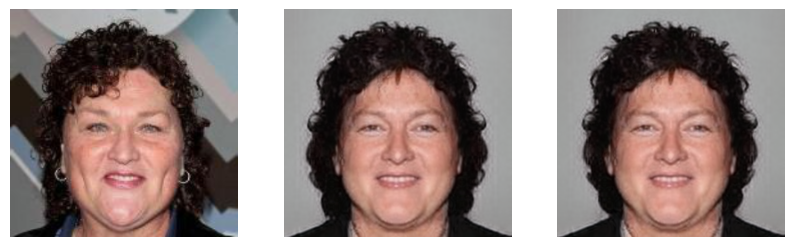

In [28]:
Label = 'Attractive'    
weights_path = predDir + Label.lower() + '_weights.pt'
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(weights_path))
model.eval()

torch.manual_seed(1)
w_im_idx = 5 # Or young & 21
w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)

with torch.no_grad():
    pred_og = torch.sigmoid(model(image_tensor)).item()
    image_orig = image_tensor.cpu().permute(1,2,0)

    w = torch.stack((w_vec,)*G.num_ws)
    image_og_recon = helper.latent_to_image(G, w).clamp(0,1)[0]
    pred_recon = torch.sigmoid(model(image_og_recon)).item()
    image_og_recon = image_og_recon.cpu().permute(1,2,0)
    
    w_cf_vec = get_interfacegan_cf(w_original, logreg)
    
    w_cf = torch.stack((w_cf_vec,)*G.num_ws)
    image_cf = helper.latent_to_image(G, w_cf).clamp(0,1)
    image_cf = image_cf.cpu().squeeze().permute(1,2,0)
    
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(image_orig)
axes[0].axis('off')

axes[1].imshow(image_og_recon)
axes[1].axis('off')

axes[2].imshow(image_cf)
axes[2].axis('off')
plt.show()



In [49]:
Labels = ['Young', 'Attractive', 'Male']
corresponding_idx_option1 = [21, 5, 3]
corresponding_idx_option2 = [91, 27, 56]

results_cfs = []
torch.manual_seed(1)
for i, Label in enumerate(Labels):
    for option_idx in (corresponding_idx_option1[i], corresponding_idx_option2[i]):
        weights_path = predDir + Label.lower() + '_weights.pt'
        model = SimpleCNN().to(device)
        model.load_state_dict(torch.load(weights_path))
        model.eval()
    
        w_im_idx = option_idx
        w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)
        
    
        with torch.no_grad():
            w = torch.stack((w_vec,)*G.num_ws)
            w_original = w_vec.detach().cpu().numpy().reshape(1, -1)
            
            pred_og = torch.sigmoid(model(image_tensor)).item()
            image_orig = image_tensor.cpu().permute(1, 2, 0)
            image_og_recon = helper.latent_to_image(G, w).clamp(0, 1)[0]
            pred_recon = torch.sigmoid(model(image_og_recon)).item()
            # image_og_recon = image_og_recon.cpu().permute(1, 2, 0)

            # Move in terms of original figures, not the predictor
            
            og_pred_glm = logreg.predict_proba(w_original)[0,1]
            if pred_recon < 0.5:
                desired_pred = 0.75 if og_pred_glm < 0.75 else 0.9
            else:
                desired_pred = 0.25 if og_pred_glm > 0.25 else 0.1
            
            w_cf_vec = get_interfacegan_cf(w_original, logreg, desired_pred)
            w_cf = torch.stack((w_cf_vec,)*G.num_ws)
            image_cf = helper.latent_to_image(G, w_cf).clamp(0, 1)
            pred_cf = torch.sigmoid(model(image_cf)).item()
            
            
            print(f'OG Prediction (GLM): {og_pred_glm:.3f}')
            print(f'OG Prediction (NN): {pred_recon:.3f}')
            print(f'CF Prediction (NN): {pred_cf:.3f}')
            print("#"*20)
            image_cf = image_cf.cpu().squeeze().permute(1, 2, 0)
    
        w_sklearn = w_vec.detach().cpu().reshape(1, -1)
        probs_og = np.array([logreg.predict_proba(w_sklearn)[0, 1] for _, logreg in filtered_logregs.items()])
        w_cf_sklearn = w_cf_vec.detach().cpu().reshape(1, -1)
        probs_cf = np.array([logreg.predict_proba(w_cf_sklearn)[0, 1] for _, logreg in filtered_logregs.items()])
    
        changes = probs_cf - probs_og
        abs_changes = np.abs(changes)
        order = np.argsort(abs_changes)[::-1]
    
        ordered_cols = clean_Ys.columns[~clean_Ys.columns.isin(exclude_cols)][order]
        ordered_changes = changes[order]
    
        num_features = 5
        top_names, top_vals = ordered_cols[:num_features], ordered_changes[:num_features]
    
        results_cf = (image_orig, image_cf, top_names, top_vals)
        results_cfs.append(results_cf)

OG Prediction (GLM): 0.000
OG Prediction (NN): 0.995
CF Prediction (NN): 0.985
####################
OG Prediction (GLM): 0.988
OG Prediction (NN): 0.918
CF Prediction (NN): 0.959
####################
OG Prediction (GLM): 0.428
OG Prediction (NN): 0.000
CF Prediction (NN): 0.000
####################
OG Prediction (GLM): 0.001
OG Prediction (NN): 0.911
CF Prediction (NN): 0.837
####################
OG Prediction (GLM): 0.019
OG Prediction (NN): 0.093
CF Prediction (NN): 0.872
####################
OG Prediction (GLM): 0.998
OG Prediction (NN): 0.979
CF Prediction (NN): 0.806
####################


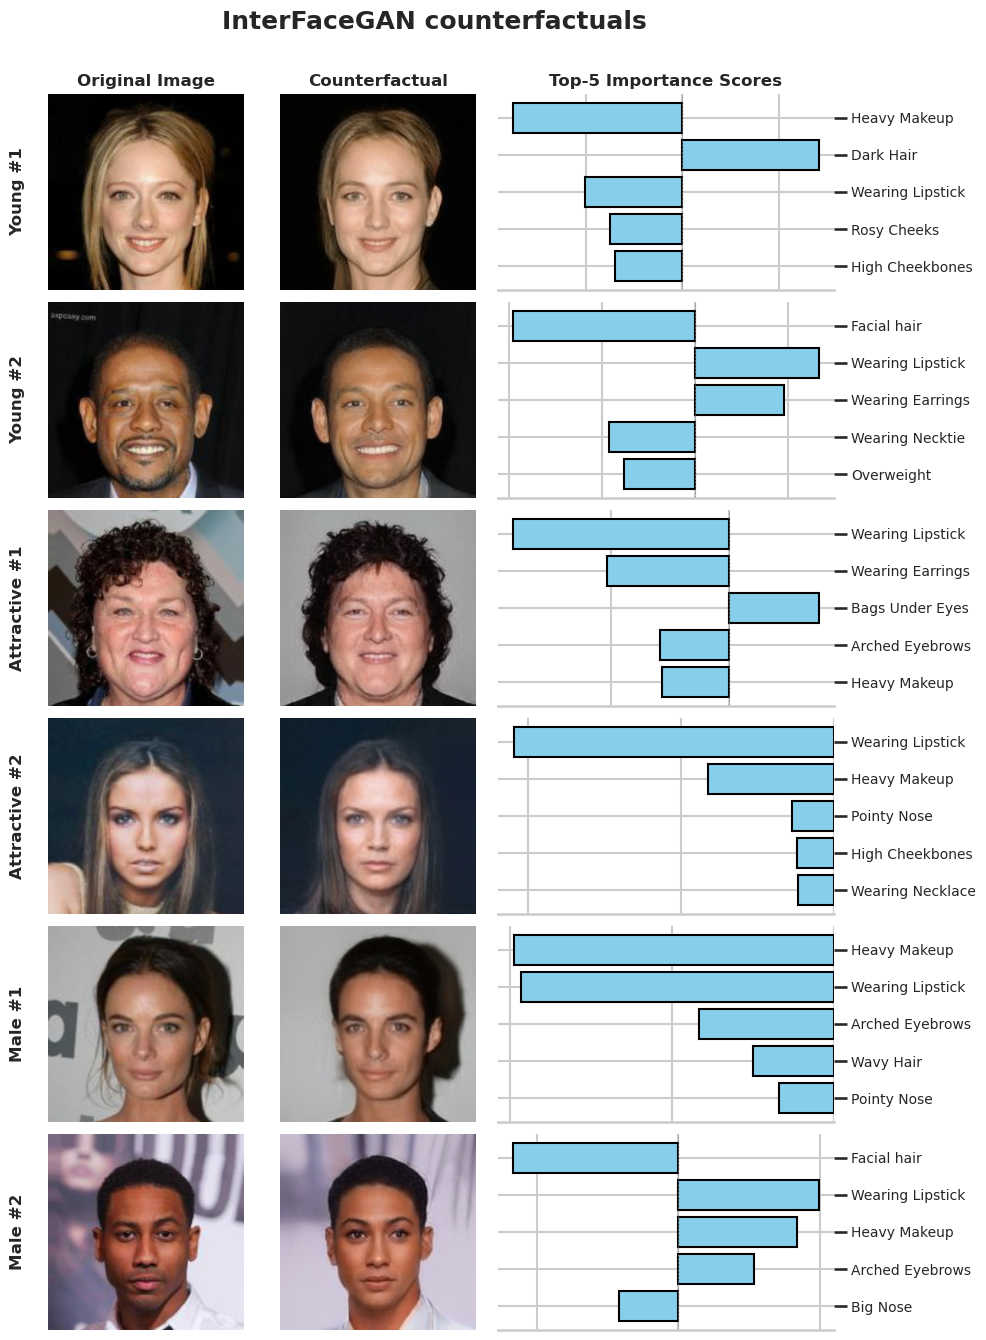

In [50]:

rows = 6
fig = plt.figure(figsize=(8, 12))
margin = 0.01
x = (1.0 - 2 * margin) / 3.5
y = (1.0 - 2 * margin) / rows
axes = [[None] * 3 for _ in range(rows)]
for i in range(rows):
    bottom = (rows - i - 1) * (y + margin)
    left0 = 0.0
    axes[i][0] = fig.add_axes([left0, bottom, x, y])
    left1 = x + margin
    axes[i][1] = fig.add_axes([left1, bottom, x, y])
    left2 = 2 * x + 2 * margin
    axes[i][2] = fig.add_axes([left2, bottom, 1.5 * x, y])
axes[0][0].set_title("Original Image", fontsize=12, fontweight='bold')
axes[0][1].set_title("Counterfactual", fontsize=12, fontweight='bold')
axes[0][2].set_title("Top-5 Importance Scores", fontsize=12, fontweight='bold')
for i, (image_orig, image_cf, top_names, top_vals) in enumerate(results_cfs):
    axes[i][0].imshow(image_orig)
    axes[i][0].axis('off')
    axes[i][1].imshow(image_cf)
    axes[i][1].axis('off')
    modified_top_names = [name.replace("_", " ") for name in top_names]
    axes[i][2].barh(modified_top_names, top_vals, color="skyblue", edgecolor="black")
    axes[i][2].invert_yaxis()
    axes[i][2].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    axes[i][2].yaxis.tick_right()
    axes[i][2].yaxis.set_label_position("right")
    sns.despine(ax=axes[i][2], top=True, left=True)
    axes[i][2].tick_params(axis='y', labelsize=10)
    axes[i][2].tick_params(axis='x', labelbottom=False)
    label_index = i // 2
    option_num = i % 2 + 1
    row_center = (rows - i - 1) * (y + margin) + y / 2
    fig.text(-0.03, row_center, f'{Labels[label_index]} #{option_num}', rotation=90, va='center', ha='left', fontsize=12, fontweight='bold')
os.makedirs("Figures", exist_ok=True)

fig.suptitle("InterFaceGAN counterfactuals", fontsize=18, fontweight='bold', y=1.1)
plt.savefig("Figures/CelebA/labeled_interfacegan.pdf", bbox_inches="tight", format="pdf", dpi=300) # Uncomment this to generate alternate figure
plt.show()

In [33]:
global_names = ['Young', 'Attractive', 'Male']
num_features = 5  # number of top features to show

results = {}
for label in global_names:
    weights_path = predDir + label.lower() + '_weights.pt'
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load(weights_path))
    model.eval()
    per_image_diffs = []
    for w_im_idx in range(100):   
        with torch.no_grad():
            w_vec, image_tensor = idx_to_img_and_vec(w_im_idx)
            pred_og = torch.sigmoid(model(image_tensor)).item()
            dir_sign = 1 if pred_og < 0.5 else -1
            
            w = torch.stack((w_vec,)*G.num_ws)
            w_original = w_vec.detach().cpu().numpy().reshape(1, -1)
            w_cf_vec = get_interfacegan_cf(w_original, logreg)
            w_cf = torch.stack((w_cf_vec,)*G.num_ws)
        
            w_sklearn = w_vec.detach().cpu().reshape(1, -1)
            probs_og = np.array([logreg.predict_proba(w_sklearn)[0, 1] for _, logreg in filtered_logregs.items()])
            w_cf_sklearn = w_cf_vec.detach().cpu().reshape(1, -1)
            probs_cf = np.array([logreg.predict_proba(w_cf_sklearn)[0, 1] for _, logreg in filtered_logregs.items()])
            
            diffs = probs_cf - probs_og
            diffs = diffs * dir_sign
            per_image_diffs.append(diffs)


    # Compute the average change and order features by the magnitude of change
    avg_changes = np.mean(per_image_diffs, axis=0)
    avg_abs_changes = np.abs(avg_changes)
    order = np.argsort(avg_abs_changes)[::-1]
    
    # Get the ordered feature names from clean_Ys (excluding some columns)
    ordered_cols = clean_Ys.columns[~clean_Ys.columns.isin(exclude_cols)][order]
    ordered_changes = avg_changes[order]
    
    # Select the top features
    top_names = ordered_cols[:num_features]
    top_vals = ordered_changes[:num_features]
    
    # Replace underscores with spaces for readability
    modified_top_names = [name.replace("_", " ") for name in top_names]
    results[label] = (modified_top_names, top_vals)
    

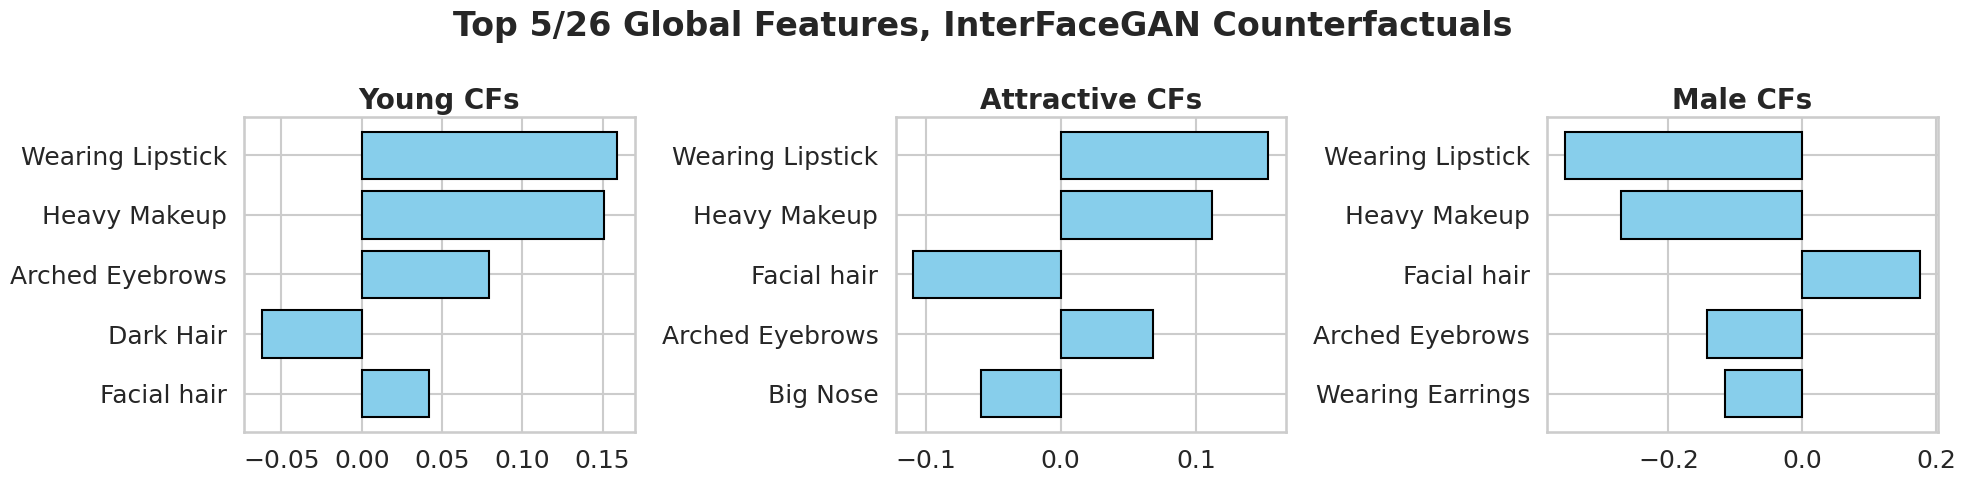

In [40]:
fig, axes = plt.subplots(1, len(global_names), figsize=(6*len(global_names)+2, 5))
fig.suptitle(f"Top {num_features}/{len(filtered_logregs)} Global Features, InterFaceGAN Counterfactuals", fontsize=24, fontweight="bold")
fig.subplots_adjust(wspace=0.4)

for i, label in enumerate(global_names):
    modified_top_names, top_vals = results[label]
    ax = axes[i]
    ax.barh(modified_top_names, top_vals, color="skyblue", edgecolor="black")
    ax.invert_yaxis()
    ax.set_title(f"{label} CFs", fontsize=20, fontweight="bold")
    # Increase the font size of both x and y tick labels (here y ticks are the feature names)
    ax.tick_params(axis="both", labelsize=18)
    
plt.tight_layout()
plt.savefig("Figures/CelebA/global_interfacegan.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()